# keras model


## pylibs


In [1]:
# Main
import os
import time

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import cv2
import random
import datetime
import gpu_control
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from keras.models import Model
import matplotlib.pyplot as plt
from keras.optimizers import SGD
from keras.regularizers import l2
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, BatchNormalization, Input, GlobalAveragePooling2D, CuDNNLSTM, concatenate, Reshape

# Utils
from Utils.one_cycle import OneCycleLr
from Utils.lr_find import LrFinder
from Utils.print_color_V2_NEW import print_Color_V2
from Utils.print_color_V1_OLD import print_Color

# Other
tf.get_logger().setLevel("ERROR")
physical_devices = tf.config.list_physical_devices("GPU")
for gpu_instance in physical_devices:
    tf.config.experimental.set_memory_growth(gpu_instance, True)

c:\Users\aydin\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\aydin\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encoun

## Conf


### Data processing conf

In [2]:
# Directory paths
train_dir = "Data_set/train"
test_dir = "Data_set/test"
validation_dir = "Data_set/val"
img_res = [224, 224, 3]
# img_res = [224, 224, 3]
# img_res = [384, 384, 3] # Very slow needs >=24Gb Vram for batch size of 1 (NR!)
interpolation_order_IFG = 2
categorical_IMP = True
Make_EV_DATA = False
R_fill_mode = True
add_img_grain = True
Save_TS = True
ADBD = 1
OP_HDC = False
SL_EX = "_V1"  # _NONOM_V1 | _V1 | _SDNP_V1
LNTS = 0
adjust_brightness_Mode = True
RANGE_NOM = True  # False for 0 to 255 True for 0 to 1 >> use False for models like ConvNeXtXLarge
scale_data_NP_M = False

### Training 

In [3]:
SAVE_TYPE = "H5"

## data processing 


In [4]:
# scale_data
def scale_data_NP(data):
    if scale_data_NP_M:
        data = data.astype("float32")
        data = (data - 127.5) / 127.5
        return data
    else:
        return data / 255


# add_image_grain
def add_image_grain(image, intensity=0.01):
    # Generate random noise array
    noise = np.random.randint(0, 255, size=image.shape, dtype=np.uint8)

    # Scale the noise array
    scaled_noise = (noise * intensity).astype(np.float32)
    # Add the noise to the image
    noisy_image = cv2.add(image, scaled_noise)

    return noisy_image


# adjust_brightness
# V1
def adjust_brightness(images, target_average):
    # Calculate the average pixel value of all the images
    overall_average = np.mean(images)

    # Iterate over each image in the array
    for i in range(len(images)):
        # Calculate the average pixel value of the current image
        image_average = np.mean(images[i])

        # Compare the image average with the overall average
        if image_average > overall_average + 10:
            # Increase brightness by adding a constant value
            images[i] = np.clip(images[i] - random.randint(6, 25), 0, 255)
        elif image_average < overall_average - 10:
            # Decrease brightness by subtracting a constant value
            images[i] = np.clip(images[i] + random.randint(6, 25), 0, 255)

    return images


# V2 (Very slow NOT Recommended)
# def adjust_brightness(images, target_average):
#     # Calculate the average pixel value of all the images
#     overall_average = np.mean(images)

#     # Initialize a variable to keep track of the number of deleted images
#     deleted_images = 0

#     # Create a progress bar
#     pbar = tqdm(total=len(images), desc='Processing images')

#     # Iterate over each image in the array
#     for i in range(len(images)):
#         # Adjust the index to account for deleted images
#         adjusted_index = i - deleted_images

#         # Calculate the average pixel value of the current image
#         image_average = np.mean(images[adjusted_index])

#         # Compare the image average with the overall average
#         if image_average > overall_average + 50 or image_average < overall_average - 60:
#             # If the image brightness is 45 units higher than the overall average, delete the image
#             images = np.delete(images, adjusted_index, axis=0)
#             # Increment the count of deleted images
#             deleted_images += 1
#         elif image_average > overall_average + 10:
#             # Increase brightness by adding a random value between 6 and 25
#             images[adjusted_index] = np.clip(images[adjusted_index] - random.randint(6, 25), 0, 255)
#         elif image_average < overall_average - 10:
#             # Decrease brightness by subtracting a random value between 6 and 25
#             images[adjusted_index] = np.clip(images[adjusted_index] + random.randint(6, 25), 0, 255)

#         # Update the progress bar
#         pbar.update(1)

#     # Close the progress bar
#     pbar.close()


#     print(f'deleted_images: {deleted_images}')
#     return images
# apply_clahe_rgb_array
def apply_clahe_rgb_array(images, clip_limit=1.8, tile_grid_size=(8, 8)):
    # Create a CLAHE object
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    # Iterate over each image in the array
    for i in range(len(images)):
        # Split the image into color channels
        b, g, r = cv2.split(images[i])

        # Convert the channels to the appropriate format
        b = cv2.convertScaleAbs(b)
        g = cv2.convertScaleAbs(g)
        r = cv2.convertScaleAbs(r)

        # Apply adaptive histogram equalization to each channel
        equalized_b = clahe.apply(b)
        equalized_g = clahe.apply(g)
        equalized_r = clahe.apply(r)

        # Merge the equalized channels back into an image
        equalized_image = cv2.merge((equalized_b, equalized_g, equalized_r))

        # Replace the original image with the equalized image in the array
        images[i] = equalized_image

    return images


# noise_func
def noise_func(image):
    noise_type = np.random.choice(["L1", "L2", "L3", "none"])
    new_image = np.copy(image)

    if noise_type == "L3":
        intensityL2 = random.uniform(0.001, 0.024)
        intensityL1 = random.uniform(0.005, 0.026)
    else:
        intensityL2 = random.uniform(0.001, 0.037)
        intensityL1 = random.uniform(0.001, 0.037)

    block_size_L1 = random.randint(16, 32)
    block_size_L2 = random.randint(32, 64)

    if noise_type == "L2" or noise_type == "L3":
        for i in range(0, image.shape[0], block_size_L2):
            for j in range(0, image.shape[1], block_size_L2):
                block = image[i : i + block_size_L2, j : j + block_size_L2]
                block = (np.random.rand() * intensityL2 + 1) * block
                new_image[i : i + block_size_L2, j : j + block_size_L2] = block
        image = new_image

    if noise_type == "L1" or noise_type == "L3":
        for i in range(0, image.shape[0], block_size_L1):
            for j in range(0, image.shape[1], block_size_L1):
                block = image[i : i + block_size_L1, j : j + block_size_L1]
                block = (np.random.rand() * intensityL1 + 1) * block
                new_image[i : i + block_size_L1, j : j + block_size_L1] = block

    if add_img_grain:
        intensity = random.uniform(0, 0.026)  # Random intensity between 0 and 0.026
        new_image = add_image_grain(new_image, intensity=intensity)
    return new_image


# shuffle_data
def shuffle_data(x, y):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    x = x[indices]
    y = y[indices]
    return x, y


# save_images_to_dir
def save_images_to_dir(images, labels, dir_path):
    # create the directory if it doesn't exist
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
    # iterate over the images and labels
    for i, (image, label) in enumerate(zip(images, labels)):
        # get the class label
        class_label = np.argmax(label)
        # create the file path
        file_path = os.path.join(dir_path, f"image_{i}_class_{class_label}.png")
        # save the image to the file path
        plt.imsave(file_path, image.squeeze())


# Create an ImageDataGenerator for the training set
if OP_HDC:
    print_Color("Using OP_HDC IDG...", ["yellow"])
    train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=179,
        zoom_range=0.24,
        shear_range=0.22,
        width_shift_range=0.21,
        brightness_range=(0.86, 1.13),
        height_shift_range=0.21,
        channel_shift_range=100,
        featurewise_center=False,
        featurewise_std_normalization=False,
        interpolation_order=interpolation_order_IFG,
        fill_mode="nearest",  # constant
        preprocessing_function=noise_func,
    )
else:
    print_Color("Using Def IDG...", ["yellow"])
    train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=179,
        zoom_range=0.26,
        shear_range=0.25,
        width_shift_range=0.25,
        brightness_range=(0.8, 1.2),
        height_shift_range=0.25,
        channel_shift_range=100,
        featurewise_center=False,
        interpolation_order=interpolation_order_IFG,
        featurewise_std_normalization=False,
        fill_mode="nearest",  # constant
        preprocessing_function=noise_func,
    )
train_datagen_SM = ImageDataGenerator(
    horizontal_flip=False,
    vertical_flip=False,
    rotation_range=20,
    zoom_range=0.07,
    shear_range=0.07,
    width_shift_range=0.07,
    brightness_range=(0.99, 1.01),
    height_shift_range=0.07,
    channel_shift_range=0,
    featurewise_center=False,
    interpolation_order=interpolation_order_IFG,
    featurewise_std_normalization=False,
)
# Create an iterator for the training set
train_generator_SM = train_datagen_SM.flow_from_directory(
    train_dir, target_size=(img_res[0], img_res[1]), batch_size=sum([len(files) for r, d, files in os.walk(train_dir)]), class_mode="binary"
)
# Create an ImageDataGenerator for the validation set (OP)
if Make_EV_DATA:
    val_datagen = ImageDataGenerator(
        horizontal_flip=False, zoom_range=0.01, width_shift_range=0.01, interpolation_order=interpolation_order_IFG, height_shift_range=0.01
    )

    # Create an iterator for the validation set
    val_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_res[0], img_res[1]),
        batch_size=sum([len(files) for r, d, files in os.walk(validation_dir)]),
        class_mode="binary",
        color_mode="rgb",
    )

    # Create an ImageDataGenerator for the test set
    test_datagen = ImageDataGenerator(
        horizontal_flip=False, zoom_range=0.01, width_shift_range=0.01, interpolation_order=interpolation_order_IFG, height_shift_range=0.01
    )

    # Create an iterator for the test set
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_res[0], img_res[1]),
        batch_size=sum([len(files) for r, d, files in os.walk(test_dir)]),
        class_mode="binary",
        color_mode="rgb",
    )
# Load all images and labels into memory
print_Color("Loading all images and labels into memory...", ["yellow"])
x_train, y_train = next(iter(train_generator_SM))
if Make_EV_DATA:
    x_val, y_val = next(iter(val_generator))
    x_test, y_test = next(iter(test_generator))
# fit parameters from data
# train_datagen.fit(x_train)
# to_categorical (TEMP)
if categorical_IMP:
    print_Color("Making categorical data...", ["yellow"])
    y_train = to_categorical(y_train, num_classes=2)
    if Make_EV_DATA:
        y_val = to_categorical(y_val, num_classes=2)
        y_test = to_categorical(y_test, num_classes=2)
print_Color(
    f"~*Generating augmented data ~*[~*ADBD: ~*{str(ADBD)}~*]~*...",
    ["yellow", "cyan", "green", "red", "cyan", "yellow"],
    advanced_mode=True,
)
if ADBD > 0:
    for i in range(ADBD):
        # ADB_clip_limit Scheduler>>>
        if i == 0:
            ADB_clip_limit = 1.6
        else:
            # V1>>>
            CL_SLM = 2.4
            ADB_clip_limit = max(2 / (i + 1) ** CL_SLM, 0.05)
            # Try it in win graphing calculator copy and paste:
            #  ┌-------------┬--┬---------------┐
            #  │ 𝑦=2/(𝑥+1)^𝑧 ├OR┤ 𝑦=2/(𝑥+1)^2.4 │
            #  └-------------┴--┴---------------┘
            # V2>>>
            # CL_SLM_2 = 1.4
            # CL_SLM_Start_2 = 2
            # ADB_clip_limit = CL_SLM_Start_2/(i+1)**(i+CL_SLM_2)
            # Try it in win graphing calculator copy and paste:
            #  ┌-----------------┬--┬-------------------┐
            #  │ 𝑦=2/(𝑥+1)^(𝑥+𝑉) ├OR┤ 𝑦=2/(𝑥+1)^(𝑥+1.4) │
            #  └-----------------┴--┴-------------------┘
        print(f">   Generating ADB[{i + 1}/{ADBD}]...")
        # prepare an iterators to scale images
        train_iterator = train_datagen.flow(x_train, y_train, batch_size=len(x_train))

        # get augmented data
        x_train_augmented, y_train_augmented = train_iterator.next()
        print(">   ├───Applying adaptive histogram equalization...")
        print(f">   ├───Adaptive histogram equalization clip limit = {round(ADB_clip_limit, 2)}")
        x_train_augmented = np.clip(x_train_augmented, 0, 255)
        # print_Color(f'~*>   |---Grayscale range: ~*Min = {np.min(x_train_augmented)}~* | ~*Max = {np.max(x_train_augmented)}', ['normal', 'blue', 'normal', 'red'], advanced_mode=True)
        x_train_augmented = apply_clahe_rgb_array(x_train_augmented, clip_limit=ADB_clip_limit)  # compensating the image info loss
        print(">   └───Adding the Generated ADB...")
        # append augmented data to original data
        x_train = np.concatenate([x_train, x_train_augmented])
        y_train = np.concatenate([y_train, y_train_augmented])
        # free up memory
        del y_train_augmented
        del x_train_augmented
# normalizing
print_Color("Normalizing image data...", ["yellow"])
if adjust_brightness_Mode:
    x_train = adjust_brightness(x_train, np.mean(x_train))
x_train = np.clip(x_train, 0, 255)
if RANGE_NOM:
    x_train = scale_data_NP(x_train)
y_train = np.array(y_train)
if Make_EV_DATA:
    x_test = np.clip(x_test, 0, 255)
    x_val = np.clip(x_val, 0, 255)
    if RANGE_NOM:
        x_val = scale_data_NP(x_val)
    y_val = np.array(y_val)
    if RANGE_NOM:
        x_test = scale_data_NP(x_test)
    y_test = np.array(y_test)
# Check the range of image data
print_Color(
    f"~*Grayscale range: ~*Min = {np.min(x_train)}~* | ~*Max = {np.max(x_train)}", ["normal", "blue", "normal", "red"], advanced_mode=True
)
# Check the data type of image data
print_Color(f"~*Data type: ~*{x_train.dtype}", ["normal", "green"], advanced_mode=True)
# Calculate the ratio of two labels
if categorical_IMP:
    label_ratio = np.sum(y_train[:, 0]) / (np.sum(y_train[:, 1]) + 1e-10)
else:
    label_ratio = np.sum(y_train == 0) / (np.sum(y_train == 1) + 1e-10)
label_ratio_percentage = label_ratio * 100
print_Color(
    f"~*Label ratio: ~*{100 - label_ratio_percentage:.2f}% PNEUMONIA ~*| ~*{label_ratio_percentage:.2f}% NORMAL",
    ["normal", "red", "magenta", "green"],
    advanced_mode=True,
)
print_Color("Setting LNTS...", ["yellow"])
# Get the total number of samples in the arrays
num_samples = x_train.shape[0]
print_Color(f"~*Original num_samples: ~*{num_samples}", ["normal", "green"], advanced_mode=True)
if LNTS != 0:
    print_Color(f"~*Applying LNTS of: ~*{LNTS}", ["normal", "green"], advanced_mode=True)
    print_Color(f"~*SNC: ~*{num_samples - LNTS}", ["normal", "green"], advanced_mode=True)
    # Generate random indices to select LNTS samples
    indices = np.random.choice(num_samples, size=LNTS, replace=False)
    # Select the samples using the generated indices
    x_selected = x_train[indices]
    y_selected = y_train[indices]
    x_train = x_selected
    y_train = y_selected
    # free up memory
    del x_selected
    del y_selected
    del indices
    # Debug
    num_samples = x_train.shape[0]
    print_Color(f"~*New num_samples: ~*{num_samples}", ["normal", "green"], advanced_mode=True)
# Shuffle the training data
print_Color("shuffling data...", ["yellow"])
x_train, y_train = shuffle_data(x_train, y_train)
# save_images_to_dir
if Save_TS:
    print_Color("Saving TS...", ["yellow"])
    SITD = np.random.choice(num_samples, size=400, replace=False)
    S_dir = "Samples/TSR400_" + datetime.datetime.now().strftime("y%Y_m%m_d%d-h%H_m%M_s%S")
    print_Color(f"~*Sample dir: ~*{S_dir}", ["normal", "green"], advanced_mode=True)
    if RANGE_NOM:
        if scale_data_NP_M:
            save_images_to_dir((x_train[SITD] + 1) / 2.0, y_train[SITD], S_dir)
        else:
            save_images_to_dir(x_train[SITD], y_train[SITD], S_dir)
    else:
        save_images_to_dir(x_train[SITD] / 255, y_train[SITD], S_dir)
print_Color("Done.", ["green"])

Using Def IDG...
Found 8818 images belonging to 2 classes.
Loading all images and labels into memory...
Making categorical data...
Generating augmented data [ADBD: 1]...
>   Generating ADB[1/1]...
>   ├───Applying adaptive histogram equalization...
>   ├───Adaptive histogram equalization clip limit = 1.6
>   └───Adding the Generated ADB...
Normalizing image data...
Grayscale range: Min = 0.0 | Max = 1.0
Data type: float32
Label ratio: 44.62% PNEUMONIA | 55.38% NORMAL
Setting LNTS...
Original num_samples: 17636
shuffling data...
Saving TS...
Sample dir: Samples/TSR400_y2023_m11_d13-h20_m09_s53
Done.


## Save EV Dataset

In [ ]:
np.save(f"Database\\x_val{SL_EX}.npy", x_val)
np.save(f"Database\\y_val{SL_EX}.npy", y_val)
np.save(f"Database\\x_test{SL_EX}.npy", x_test)
np.save(f"Database\\y_test{SL_EX}.npy", y_test)

## Load EV Dataset

In [5]:
x_val = np.load(f"Database\\x_val{SL_EX}.npy")
y_val = np.load(f"Database\\y_val{SL_EX}.npy")
x_test = np.load(f"Database\\x_test{SL_EX}.npy")
y_test = np.load(f"Database\\y_test{SL_EX}.npy")

## Creating the model


### Rev1
```
statuses: Ready
Working: ✅
Max fine tuned acc: ≅95.1
Max fine tuned acc TLRev2: N/A
type: transfer learning>>>(EfficientNetB7)
```

In [14]:
from keras.applications import EfficientNetB7

EfficientNet_M = EfficientNetB7(
    include_top=True, input_shape=(img_res[0], img_res[1], img_res[2]), weights=None, classes=2, classifier_activation="softmax"
)
# define new model
model = Model(inputs=EfficientNet_M.inputs, outputs=EfficientNet_M.outputs)

# compile model
opt = SGD(momentum=0.9)
# opt = SGD(learning_rate=0.008, momentum=0.85, decay=0.001)
# opt = Adam()
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

### Rev1.1
```
statuses: S.Ready (can improve)
Working: ✅
Max fine tuned acc: ≅93.2
Max fine tuned acc TLRev2: N/A
type: transfer learning>>>(ConvNeXtLarge)
```

In [ ]:
from keras.applications import ConvNeXtLarge

ConvNeXtLarge_M = ConvNeXtLarge(
    include_top=True, input_shape=(img_res[0], img_res[1], img_res[2]), weights=None, classes=2, classifier_activation="softmax"
)
# define new model
model = Model(inputs=ConvNeXtLarge_M.inputs, outputs=ConvNeXtLarge_M.outputs)

# compile model
opt = SGD(learning_rate=0.008, momentum=0.85, decay=0.001)
# opt = SGD(learning_rate=0.008, momentum=0.85, decay=0.001)
# opt = Adam()
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy", "binary_accuracy"])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 convnext_large_prestem_normali  (None, 224, 224, 3)  0          ['input_1[0][0]']                
 zation (Normalization)                                                                           
                                                                                                  
 convnext_large_stem (Sequentia  (None, 56, 56, 192)  9792       ['convnext_large_prestem_normaliz
 l)                                                              ation[0][0]']                

### Rev1.2
```
statuses: Ready
Working: ✅
Max fine tuned acc: 95.3
Max fine tuned acc TLRev2: 96.96
type: transfer learning>>>(EfficientNetB7::CCL)
```

In [31]:
from efficientnet.keras import EfficientNetB7 as KENB7


# FUNC
def Eff_B7_NS(freeze_layers):
    base_model = KENB7(input_shape=(img_res[0], img_res[1], img_res[2]), weights="noisy-student", include_top=False)
    print("Total layers in the base model: ", len(base_model.layers))
    print(f"Freezing {freeze_layers} layers in the base model...")
    # Freeze the specified number of layers
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False

    # Unfreeze the rest
    for layer in base_model.layers[freeze_layers:]:
        layer.trainable = True

    # Calculate the percentage of the model that is frozen
    frozen_percentage = ((freeze_layers + 1e-10) / len(base_model.layers)) * 100
    print(f"Percentage of the base model that is frozen: {frozen_percentage:.2f}%")
    # adding CDL
    base_model_FT = GlobalAveragePooling2D()(base_model.output)
    Dense_L1 = Dense(512, activation="relu", kernel_regularizer=l2(0.02))(base_model_FT)
    Dropout_L1 = Dropout(0.1)(Dense_L1)
    BatchNorm_L2 = BatchNormalization()(Dropout_L1)
    Dense_L2 = Dense(512, activation="relu", kernel_regularizer=l2(0.01))(BatchNorm_L2)
    BatchNorm_L3 = BatchNormalization()(Dense_L2)
    Dense_L3 = Dense(128, activation="relu")(BatchNorm_L3)
    predictions = Dense(2, activation="softmax")(Dense_L3)

    model_EfficientNetB7_NS = Model(inputs=base_model.input, outputs=predictions)
    print("Total model layers: ", len(model_EfficientNetB7_NS.layers))
    # OPT/compile
    opt = SGD(momentum=0.9)
    # opt = Yogi()
    model_EfficientNetB7_NS.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

    return model_EfficientNetB7_NS


print("Creating the model...")
# Main
freeze_layers = 0
model = Eff_B7_NS(freeze_layers)
model.summary(show_trainable=True, expand_nested=True)
print("done.")

Creating the model...
Total layers in the base model:  806
Freezing 0 layers in the base model...
Percentage of the base model that is frozen: 0.00%
Total model layers:  814
Model: "model_10"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               Y          
                                )]                                                                           
                                                                                                             
 stem_conv (Conv2D)             (None, 112, 112, 64  1728        ['input_1[0][0]']                Y          
                                )                                                                            
                                      

### Rev1.3
```
statuses: Test
Working: ✅
Max fine tuned acc: ⚠️
Max fine tuned acc TLRev2: ⚠️
type: transfer learning>>>(EfficientNetB7|Xception::CCL)
```

In [ ]:
from keras.applications.xception import Xception


# FUNC
def Combo_Model(freeze_layers1, freeze_layers2):
    # Define a common input
    common_input = Input(shape=(img_res[0], img_res[1], img_res[2]))

    # Base model 1
    base_model1 = KENB7(input_shape=(img_res[0], img_res[1], img_res[2]), weights=None, include_top=False)
    # base_model1.load_weights('models\Ready\Other\EfficientNetB7_PRET.h5', by_name=True, skip_mismatch=True)
    base_model1_out = base_model1(common_input)

    # Base model 2
    base_model2 = Xception(input_shape=(img_res[0], img_res[1], img_res[2]), weights=None, include_top=False)
    # base_model1.load_weights('models\Ready\Other\Xception_PRET.h5', by_name=True, skip_mismatch=True)
    base_model2_out = base_model2(common_input)

    print("Total base_model1 layers: ", len(base_model1.layers))
    print("Total base_model2 layers: ", len(base_model2.layers))

    # Freeze the specified number of layers in both models
    for layer in base_model1.layers[:freeze_layers1]:
        layer.trainable = False
    for layer in base_model2.layers[:freeze_layers2]:
        layer.trainable = False

    # Unfreeze the rest in both models
    for layer in base_model1.layers[freeze_layers1:]:
        layer.trainable = True
    for layer in base_model2.layers[freeze_layers2:]:
        layer.trainable = True

    # Combine the output of the two base models
    combined = concatenate([base_model1_out, base_model2_out])

    # adding CDL
    base_model_FT = GlobalAveragePooling2D()(combined)
    Dense_L1 = Dense(2048, activation="relu", kernel_regularizer=l2(0.04))(base_model_FT)
    Dropout_L1 = Dropout(0.4)(Dense_L1)
    BatchNorm_L2 = BatchNormalization()(Dropout_L1)
    Dense_L2 = Dense(512, activation="relu", kernel_regularizer=l2(0.02))(BatchNorm_L2)
    BatchNorm_L3 = BatchNormalization()(Dense_L2)
    Dense_L3 = Dense(128, activation="relu")(BatchNorm_L3)
    predictions = Dense(2, activation="softmax")(Dense_L3)

    combo_model = Model(inputs=common_input, outputs=predictions)
    print("Total model layers: ", len(combo_model.layers))

    # OPT/compile
    opt = SGD(momentum=0.9)
    combo_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

    return combo_model


print("Creating the model...")
# Main
freeze_layers_1 = 0
freeze_layers_2 = 0
model = Combo_Model(freeze_layers_1, freeze_layers_2)
model.summary(show_trainable=True, expand_nested=True)
print("done.")

Creating the model...
Total base_model1 layers:  806
Total base_model2 layers:  132
Total model layers:  12
Model: "model_1"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_2 (InputLayer)           [(None, 384, 384, 3  0           []                               Y          
                                )]                                                                           
                                                                                                             
 efficientnet-b7 (Functional)   (None, 12, 12, 2560  64097680    ['input_2[0][0]']                Y          
                                )                                                                            
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯

### Rev1.4
```
statuses: Test
Working: ✅
Max fine tuned acc: ⚠️
Max fine tuned acc TLRev2: ≅95.64
type: transfer learning>>>(EfficientNetV2XL)
```

In [8]:
from keras_efficientnet_v2 import EfficientNetV2XL

EfficientNet_M = EfficientNetV2XL(
    input_shape=(img_res[0], img_res[1], img_res[2]), pretrained="imagenet21k-ft1k", num_classes=2, dropout=0.5
)
# define new model
model = Model(inputs=EfficientNet_M.inputs, outputs=EfficientNet_M.outputs)

# compile model
opt = SGD(momentum=0.9)
# opt = AdaBeliefOptimizer(epsilon=1e-7, rectify=False, weight_decay=1e-3)
# opt = Adam()
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

freeze_layers = 0
model.summary(show_trainable=True, expand_nested=True)
print("done.")

>>>> Load pretrained from: C:\Users\aydin\.keras\models/efficientnetv2\efficientnetv2-xl-21k-ft1k.h5
Model: "model"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               Y          
                                )]                                                                           
                                                                                                             
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['input_1[0][0]']                Y          
                                )                                                                            
                                                                                                             
 ste

### V(T) Beta

In [22]:
# FUNC
def Eff_B7_NS(freeze_layers):
    base_model = KENB7(input_shape=(img_res[0], img_res[1], img_res[2]), weights="noisy-student", include_top=False)
    print("Total layers in the base model: ", len(base_model.layers))
    print(f"Freezing {freeze_layers} layers in the base model...")
    # Freeze the specified number of layers
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False

    # Unfreeze the rest
    for layer in base_model.layers[freeze_layers:]:
        layer.trainable = True

    # Calculate the percentage of the model that is frozen
    frozen_percentage = ((freeze_layers + 1e-10) / len(base_model.layers)) * 100
    print(f"Percentage of the base model that is frozen: {frozen_percentage:.2f}%")

    # adding LSTM layers
    lstm_seq_length = 49
    lstm_input_shape = (lstm_seq_length, base_model.output_shape[1])
    reshape_layer = Reshape(target_shape=(lstm_seq_length, -1))(base_model.output)
    lstm_layer = CuDNNLSTM(512, input_shape=lstm_input_shape)(reshape_layer)

    # adding dense layers
    Dense_L1 = Dense(1024, activation="relu", kernel_regularizer=l2(0.04))(lstm_layer)
    Dropout_L1 = Dropout(0.4)(Dense_L1)
    BatchNorm_L2 = BatchNormalization()(Dropout_L1)
    Dense_L2 = Dense(512, activation="relu", kernel_regularizer=l2(0.02))(BatchNorm_L2)
    BatchNorm_L3 = BatchNormalization()(Dense_L2)
    Dense_L3 = Dense(128, activation="relu")(BatchNorm_L3)
    predictions = Dense(2, activation="softmax")(Dense_L3)

    model_EfficientNetB7_NS = Model(inputs=base_model.input, outputs=predictions)
    print("Total model layers: ", len(model_EfficientNetB7_NS.layers))

    # OPT/compile
    opt = SGD(momentum=0.9)
    # opt = Yogi()
    model_EfficientNetB7_NS.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

    return model_EfficientNetB7_NS


print("Creating the model...")
# Main
freeze_layers = 0
model = Eff_B7_NS(freeze_layers)
model.summary(show_trainable=True, expand_nested=True)
print("done.")

Creating the model...
Total layers in the base model:  806
Freezing 0 layers in the base model...
Percentage of the base model that is frozen: 0.00%
Total model layers:  815
Model: "model_1"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               Y          
                                )]                                                                           
                                                                                                             
 stem_conv (Conv2D)             (None, 112, 112, 64  1728        ['input_2[0][0]']                Y          
                                )                                                                            
                                       

### V(T) Beta2

In [ ]:
from keras.applications import InceptionResNetV2


# FUNC
def Eff_B7_NS(freeze_layers):
    base_model = InceptionResNetV2(input_shape=(img_res[0], img_res[1], img_res[2]), weights=None, include_top=False)
    print("Total layers in the base model: ", len(base_model.layers))
    print(f"Freezing {freeze_layers} layers in the base model...")
    # Freeze the specified number of layers
    for layer in base_model.layers[:freeze_layers]:
        layer.trainable = False

    # Unfreeze the rest
    for layer in base_model.layers[freeze_layers:]:
        layer.trainable = True

    # Calculate the percentage of the model that is frozen
    frozen_percentage = ((freeze_layers + 1e-10) / len(base_model.layers)) * 100
    print(f"Percentage of the base model that is frozen: {frozen_percentage:.2f}%")
    # adding CDL
    base_model_FT = GlobalAveragePooling2D()(base_model.output)
    Dense_L1 = Dense(1024, activation="relu", kernel_regularizer=l2(0.04))(base_model_FT)
    Dropout_L1 = Dropout(0.4)(Dense_L1)
    BatchNorm_L2 = BatchNormalization()(Dropout_L1)
    Dense_L2 = Dense(512, activation="relu", kernel_regularizer=l2(0.02))(BatchNorm_L2)
    BatchNorm_L3 = BatchNormalization()(Dense_L2)
    Dense_L3 = Dense(128, activation="relu")(BatchNorm_L3)
    predictions = Dense(2, activation="softmax")(Dense_L3)

    model_EfficientNetB7_NS = Model(inputs=base_model.input, outputs=predictions)
    print("Total model layers: ", len(model_EfficientNetB7_NS.layers))
    # OPT/compile
    opt = SGD(momentum=0.9)
    # opt = Yogi()
    model_EfficientNetB7_NS.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

    return model_EfficientNetB7_NS


print("Creating the model...")
# Main
freeze_layers = 0
model = Eff_B7_NS(freeze_layers)
model.summary(show_trainable=True, expand_nested=True)
print("done.")

Creating the model...
Total layers in the base model:  780
Freezing 0 layers in the base model...
Percentage of the base model that is frozen: 0.00%
Total model layers:  788
Model: "model"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_1 (InputLayer)           [(None, 384, 384, 3  0           []                               Y          
                                )]                                                                           
                                                                                                             
 conv2d (Conv2D)                (None, 191, 191, 32  864         ['input_1[0][0]']                Y          
                                )                                                                            
                                         

### LR FINDER

In [ ]:
import gc

# Garbage Collection (memory)
gc.collect()
tf.keras.backend.clear_session()
# CONF/Other
LRF_OPT = SGD(momentum=0.9)
LFR_batch_size = 1  # or any other batch size that fits in your memory
LRF_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(LFR_batch_size)
# Instantiate LrFinder
lr_find = LrFinder(model, LRF_OPT, tf.keras.losses.categorical_crossentropy)

# Start range_test
lr_find.range_test(LRF_dataset)
lr_find.plot_lrs(skip_end=0, suggestion=True, show_grid=True)

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

## Loading the model

### Loading the full model

In [6]:
# Configuration
PRMC = False
freeze_from_opposite = True
Extra_EXT = "_T"
freeze_layers = 0
randomly_frozen_layers = 0
freeze_last_seven = False
# CEC_opt = Adagrad()
# CEC_opt = Yogi()
# CEC_opt = AdaBeliefOptimizer(epsilon=1e-7, rectify=False, weight_decay=1e-3)
CEC_opt = SGD(momentum=0.9, nesterov=False)
# CEC_opt = Adam()
# Main
try:
    if SAVE_TYPE == "TF":
        model = load_model(f"PAI_model{Extra_EXT}", compile=PRMC)
    else:
        model = load_model(f"PAI_model{Extra_EXT}.h5", compile=PRMC)
except (ImportError, IOError) as e:
    print(f"\033[91mfailed to load the model ERROR:\n{e}")
else:
    print("\033[92mLoading model done.")
    if not PRMC:
        print("Compiling the AI model...\033[0m")

        for layer in model.layers:
            layer.trainable = True

        # Select random layers to freeze
        frozen_layer_indices = random.sample(range(len(model.layers)), randomly_frozen_layers)

        for i, layer in enumerate(model.layers):
            if i in frozen_layer_indices:
                layer.trainable = False
            else:
                if freeze_from_opposite and (i > len(model.layers) - freeze_layers):
                    layer.trainable = False
                elif (not freeze_from_opposite) and i < freeze_layers:
                    layer.trainable = False
                else:
                    layer.trainable = True

        for layer in model.layers[-7:]:
            layer.trainable = not freeze_last_seven

        model.compile(optimizer=CEC_opt, loss="categorical_crossentropy", metrics=["accuracy"])
        model.summary(show_trainable=True, expand_nested=True)
        print("done.")

Loading model done.
Compiling the AI model...
Model: "model_10"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               Y          
                                )]                                                                           
                                                                                                             
 stem_conv (Conv2D)             (None, 112, 112, 64  1728        ['input_1[0][0]']                Y          
                                )                                                                            
                                                                                                             
 stem_bn (BatchNormalization)   (None, 112, 112, 64  256

### Loading model weights

In [ ]:
model.load_weights("PAI_model_weights.h5")
print("done.")

done.


## Training

#### Usage:
##### Start with Rev2 if it didnt work train it a little bit with Rev1 and then train it with Rev2
##### flowchart:
![FC](TRAIN_FC.png)  

#### Rev2 (THE BEST)
```
Working: ✅
Other:
 - Tensorboard doesn't work.
 + Perverts overfitting.
 - Slow training.
 + Achieving higher acc.
 - Some models dont work.
```

In [32]:
import gc

# Garbage Collection (memory)
gc.collect()
tf.keras.backend.clear_session()
# CONF
max_epoch = 256  # 128 for small models 256 for full Fine tuning and big models
subset_epoch = 8  # change it if you are using a combined model or a big one| DEF=6 / COMM=8 | Too little can result the model not Learn the patterns and too much makes the model overfit on that subset and perform badly on the next subset
subset_epoch_FT = 6
PL_epoch = 16  # <=16 for small models and >=24 for big models
subset_size = 2048
Conf_batch_size_REV2 = 8
OneCycleLr_MAXLR = 0.01
OneCycleLr_DEC_A = 0.0005
OneCycleLr_MINLR = 0.0015
TerminateOnHighTemp_M = (
    True  # can make your training a little bit slower, but it can save your expensive gpu (TURN IT OFF FOR TPU OR CPU TRAINING)
)
Use_ES_ONSUBT = False
EarlyStopping_P = 5
BEST_RSN = "PAI_model_T"
# VAR
OneCycleLr_CUNLR = OneCycleLr_MAXLR
all_histories = []
best_acc = 0
best_loss = float("inf")


# Funcs
def add_image_grain_TRLRev2(image, intensity=0.01):
    # Generate random noise array
    noise = np.random.randint(0, 255, size=image.shape, dtype=np.uint8)

    # Scale the noise array
    scaled_noise = (noise * intensity).astype(np.float32)
    # Add the noise to the image
    noisy_image = cv2.add(image, scaled_noise)

    return noisy_image


def noise_func_TRLRev2(image):
    noise_type = np.random.choice(["L1", "L2", "L3", "none"])
    new_image = np.copy(image)

    if noise_type == "L3":
        intensityL2 = random.uniform(0.001, 0.016)
        intensityL1 = random.uniform(0.005, 0.020)
    else:
        intensityL2 = random.uniform(0.001, 0.027)
        intensityL1 = random.uniform(0.001, 0.028)

    block_size_L1 = random.randint(16, 32)
    block_size_L2 = random.randint(32, 64)

    if noise_type == "L2" or noise_type == "L3":
        for i in range(0, image.shape[0], block_size_L2):
            for j in range(0, image.shape[1], block_size_L2):
                block = image[i : i + block_size_L2, j : j + block_size_L2]
                block = (np.random.rand() * intensityL2 + 1) * block
                new_image[i : i + block_size_L2, j : j + block_size_L2] = block
        image = new_image

    if noise_type == "L1" or noise_type == "L3":
        for i in range(0, image.shape[0], block_size_L1):
            for j in range(0, image.shape[1], block_size_L1):
                block = image[i : i + block_size_L1, j : j + block_size_L1]
                block = (np.random.rand() * intensityL1 + 1) * block
                new_image[i : i + block_size_L1, j : j + block_size_L1] = block

    if add_img_grain:
        intensity = random.uniform(0, 0.022)  # Random intensity
        new_image = add_image_grain_TRLRev2(new_image, intensity=intensity)
    return new_image


# CONST
train_SUB_datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=179,
    zoom_range=0.24,
    shear_range=0.22,
    width_shift_range=0.21,
    brightness_range=(0.88, 1.12),
    height_shift_range=0.21,
    channel_shift_range=100,
    featurewise_center=False,
    featurewise_std_normalization=False,
    interpolation_order=2,
    fill_mode="nearest",
    preprocessing_function=noise_func_TRLRev2,
)


class TerminateOnHighTemp(tf.keras.callbacks.Callback):
    def __init__(self, active=True, check_every_n_batches=2, high_temp=75, low_temp=60, pause_time=60):
        super().__init__()
        self.active = active
        self.check_every_n_batches = check_every_n_batches
        self.high_temp = high_temp
        self.low_temp = low_temp
        self.pause_time = pause_time
        self.batch_counter = 0

    def on_batch_end(self, batch, logs=None):
        if not self.active:
            return
        self.batch_counter += 1
        if self.batch_counter % self.check_every_n_batches == 0:
            temperature = gpu_control.get_temperature()
            if temperature > self.high_temp:
                print_Color(f"\nPausing training due to high GPU temperature! (for [{self.pause_time}]sec)", ["red"], advanced_mode=False)
                time.sleep(self.pause_time)
                while gpu_control.get_temperature() > self.low_temp:
                    time.sleep(4)
                print_Color("Resuming training...", ["yellow"])


# callbacks
steps_per_epoch_train_SUB = subset_size // Conf_batch_size_REV2
early_stopping = EarlyStopping(monitor="val_accuracy", patience=EarlyStopping_P, verbose=1, restore_best_weights=True, mode="max")
TerminateOnHighTemp_CB = TerminateOnHighTemp(
    active=TerminateOnHighTemp_M, check_every_n_batches=5, high_temp=75, low_temp=58, pause_time=60
)
# MAIN
print("Training the model...")
try:
    for epoch in range(1, max_epoch):
        # Start Epoch
        STG = "Learning the patterns" if epoch < PL_epoch else "Fine tuning"
        C_subset_epoch = subset_epoch if epoch < PL_epoch else subset_epoch_FT
        start_FULL_time = time.time()
        print_Color(
            f"\n~*Epoch: ~*{epoch}~*/~*{max_epoch}~* | ~*[{STG}]",
            ["normal", "cyan", "normal", "green", "blue", "green"],
            advanced_mode=True,
        )
        # DP
        print_Color("Shuffling data...", ["yellow"])
        x_train, y_train = shuffle_data(x_train, y_train)
        print_Color(f"~*Taking a subset of ~*[{subset_size}]~*...", ["yellow", "green", "yellow"], advanced_mode=True)
        subset_indices = np.random.choice(x_train.shape[0], subset_size, replace=False)
        x_SUB_train = x_train[subset_indices]
        y_SUB_train = y_train[subset_indices]
        print_Color("Augmenting data...", ["yellow"])
        train_SUB_augmented_images = train_SUB_datagen.flow(
            x_SUB_train * 255, y_SUB_train, shuffle=False, batch_size=len(x_SUB_train)
        ).next()
        x_SUB_train = np.clip(train_SUB_augmented_images[0], 0, 255) / 255
        y_SUB_train = train_SUB_augmented_images[1]
        # learning_rate_schedule_SUB
        if epoch > PL_epoch and OneCycleLr_CUNLR > OneCycleLr_MINLR:
            OneCycleLr_CUNLR -= OneCycleLr_DEC_A

        learning_rate_schedule_SUB = OneCycleLr(max_lr=OneCycleLr_CUNLR, steps_per_epoch=steps_per_epoch_train_SUB, epochs=C_subset_epoch)
        # FV
        print_Color(
            f"~*Setting model OneCycleLr::maxlr to ~*[{OneCycleLr_CUNLR:.6f}]~*...", ["yellow", "green", "yellow"], advanced_mode=True
        )
        print_Color(f"~*Setting model subset epoch.c to ~*[{C_subset_epoch}]~*...", ["yellow", "green", "yellow"], advanced_mode=True)
        # Train
        print_Color("Training on subset...", ["green"])
        start_SUBO_time = time.time()
        SUB_history = model.fit(
            x_SUB_train,
            y_SUB_train,
            epochs=C_subset_epoch,
            batch_size=Conf_batch_size_REV2,
            validation_data=(x_test, y_test),
            verbose="auto",
            callbacks=[learning_rate_schedule_SUB, TerminateOnHighTemp_CB, early_stopping]
            if Use_ES_ONSUBT
            else [learning_rate_schedule_SUB, TerminateOnHighTemp_CB],
        )
        end_SUBO_time = time.time()
        print_Color("Subset training done.", ["green"])
        all_histories.append(SUB_history.history)
        # Garbage Collection (memory)
        gc.collect()
        tf.keras.backend.clear_session()
        # Evaluate the model on the test data
        evaluation = model.evaluate(x_test, y_test, verbose=0)

        # Extract the loss and accuracy from the evaluation results
        loss = evaluation[0]
        acc = evaluation[1]

        # If the accuracy is higher than the best_acc
        if acc > best_acc:
            print("Improved model accuracy from {} to {}. Saving model.".format(best_acc, acc))

            # Update the best_acc
            best_acc = acc

            # Save the model
            if SAVE_TYPE == "TF":
                print("Saving full model tf format...")
                model.save(BEST_RSN, save_format="tf")
            else:
                model.save(f"{BEST_RSN}.h5")
        else:
            print("Model accuracy did not improve from {}. Not saving model.".format(best_acc))

        # If the loss is higher than the best_loss
        if loss < best_loss:
            print("Improved model loss from {} to {}. Saving model.".format(best_loss, loss))

            # Update the best_acc
            best_loss = loss

            # Save the model
            if SAVE_TYPE == "TF":
                print("Saving full model tf format...")
                model.save(BEST_RSN + "_BL", save_format="tf")
            else:
                model.save(f"{BEST_RSN}_BL.h5")
        else:
            print("Model loss did not improve from {}. Not saving model.".format(best_loss))
        # Garbage Collection (memory)
        gc.collect()
        tf.keras.backend.clear_session()
        # Epoch end
        end_time = time.time()
        epoch_time = end_time - start_FULL_time
        print(f"Time taken for epoch(FULL) {epoch}: {epoch_time:.2f} sec")
        epoch_SUB_time = end_SUBO_time - start_SUBO_time
        print(f"Time taken for epoch(SUBo) {epoch}: {epoch_SUB_time:.2f} sec")
        print_Color(f"<---------------------------------------|Epoch [{epoch}] END|--------------------------------------->", ["cyan"])
except KeyboardInterrupt:
    print("\nKeyboardInterrupt.")
# End
history = {}
for key in all_histories[0].keys():
    # For each metric, concatenate the values from all histories
    history[key] = np.concatenate([h[key] for h in all_histories])
print("Training done.\n")

Training the model...

Epoch: 1/256 | [Learning the patterns]
Shuffling data...
Taking a subset of [2048]...
Augmenting data...
Setting model OneCycleLr::maxlr to [0.010000]...
Setting model subset epoch.c to [8]...
Training on subset...
Epoch 1/8
256/256 [==============================] - 55s 166ms/step - loss: 20.4375 - accuracy: 0.6216 - val_loss: 15.7907 - val_accuracy: 0.8157
Epoch 2/8
256/256 [==============================] - 40s 155ms/step - loss: 10.5470 - accuracy: 0.7383 - val_loss: 6.2110 - val_accuracy: 0.8205
Epoch 3/8
256/256 [==============================] - 40s 155ms/step - loss: 4.1127 - accuracy: 0.7842 - val_loss: 2.5556 - val_accuracy: 0.8702
Epoch 4/8
256/256 [==============================] - 40s 155ms/step - loss: 1.8795 - accuracy: 0.8096 - val_loss: 1.2612 - val_accuracy: 0.8718
Epoch 5/8
256/256 [==============================] - 40s 156ms/step - loss: 1.0468 - accuracy: 0.8398 - val_loss: 0.8444 - val_accuracy: 0.8686
Epoch 6/8
256/256 [====================

#### Rev1 
```
Working: ✅
Other:
 + Tensorboard works.
 - Can cause overfitting.
```

In [ ]:
import gc

# Garbage Collection (memory)
gc.collect()
tf.keras.backend.clear_session()
# CONF
WTD_augmentation = True
Conf_batch_size = 4
Learning_rate_conf = 3  # 1 and 2 for custom learning_rate_fn and 3 for OneCycleLr (Better for full training)
# TensorBoard conf
TensorBoard_UF = 1  # 1 for Slow 2 for fast (very slow tarining)
# Learning rate configuration
Learning_rate_conf_SET2C = 3  # 1 for SGD and 2 for Adam and... for lower lr 3 for very high lr
OneCycleLr_MAXLR = 0.0174
# First time
if Learning_rate_conf == 1:
    learning_rate_start = 8e-04
    learning_rate_max = 5e-03
    learning_rate_min = 5e-05
    learning_rate_rampup_epochs = 5
    learning_rate_sustain_epochs = 1
    learning_rate_exp_decay = 0.3
    # TEMP
    # learning_rate_start = 8e-04
    # learning_rate_max = 1e-02
    # learning_rate_min = 8e-04
    # learning_rate_rampup_epochs = 5
    # learning_rate_sustain_epochs = 3
    # learning_rate_exp_decay = .45
# 2th time
if Learning_rate_conf == 2:
    if Learning_rate_conf_SET2C == 1:
        learning_rate_start = 4.10e-06
        learning_rate_max = 4.10e-06
        learning_rate_min = 4.10e-06
        learning_rate_rampup_epochs = 0
        learning_rate_sustain_epochs = 0
        learning_rate_exp_decay = 0.1

    elif Learning_rate_conf_SET2C == 2:
        learning_rate_start = 4e-07
        learning_rate_max = 4e-07
        learning_rate_min = 4e-07
        learning_rate_rampup_epochs = 0
        learning_rate_sustain_epochs = 0
        learning_rate_exp_decay = 0.1

    elif Learning_rate_conf_SET2C == 3:
        learning_rate_start = 5e-04
        learning_rate_max = 5e-04
        learning_rate_min = 5e-04
        learning_rate_rampup_epochs = 0
        learning_rate_sustain_epochs = 0
        learning_rate_exp_decay = 0.1
# Function to build learning rate schedule
if Learning_rate_conf in [1, 2]:

    def build_learning_rate_fn(
        lr_start=learning_rate_start,
        lr_max=learning_rate_max,
        lr_min=learning_rate_min,
        lr_rampup_epochs=learning_rate_rampup_epochs,
        lr_sustain_epochs=learning_rate_sustain_epochs,
        lr_exp_decay=learning_rate_exp_decay,
    ):
        lr_max = lr_max * tf.distribute.get_strategy().num_replicas_in_sync

        def learning_rate_fn(epoch):
            if epoch < lr_rampup_epochs:
                lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
            elif epoch < lr_rampup_epochs + lr_sustain_epochs:
                lr = lr_max
            else:
                lr = (lr_max - lr_min) * lr_exp_decay ** (epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
            return lr

        return learning_rate_fn


# WTD_augmentation
if WTD_augmentation:
    print_Color("Using WTD_augmentation...", ["yellow"])

    def TF_add_image_grain(image, intensity=0.01):
        # Generate random noise array in the range [0, 1]
        noise = tf.random.uniform(shape=tf.shape(image), minval=0, maxval=1, dtype=tf.float32)

        # Scale the noise array
        scaled_noise = noise * intensity

        # Add the noise to the image
        noisy_image = tf.math.add(image, scaled_noise)

        # Clip
        if RANGE_NOM:
            noisy_image = tf.clip_by_value(noisy_image, -1.0, 1.0)
        else:
            noisy_image = tf.clip_by_value(noisy_image, 0.0, 255.0)

        return noisy_image

    # Function to augment images
    def augment_images(image, label):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_contrast(image, 0.2, 1.8)
        image = tf.image.random_brightness(image, max_delta=0.3)
        # Random intensity between 0 and 0.04
        intensity = random.uniform(0, 0.04)
        image = TF_add_image_grain(image, intensity=intensity)
        # Add random rotation
        # image = tf.image.rot90(image, k=random.randint(0, 3))
        return image, label

    # Create TensorFlow dataset
    AUTO = tf.data.experimental.AUTOTUNE
    train_dataset = (
        tf.data.Dataset.from_tensor_slices((x_train, y_train))
        .map(augment_images, num_parallel_calls=AUTO)
        .repeat()
        .shuffle(len(x_train))
        .batch(Conf_batch_size)
        .prefetch(AUTO)
    )

# Calculate steps per epoch
steps_per_epoch_train = len(x_train) // Conf_batch_size


# Set up callbacks
class EpochEndMON(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        optimizer = self.model.optimizer
        if hasattr(optimizer, "lr"):
            lr = tf.keras.backend.get_value(optimizer.lr)
            print(f"\nLearning rate for epoch {epoch + 1} is {lr}")
        if hasattr(optimizer, "momentum"):
            momentum = tf.keras.backend.get_value(optimizer.momentum)
            print(f"Momentum for epoch {epoch + 1} is {momentum}")
        if logs:
            val_loss = logs.get("val_loss")
            val_acc = logs.get("val_accuracy")
            print(f"Validation loss for epoch {epoch + 1} is {val_loss}")
            print(f"Validation accuracy for epoch {epoch + 1} is {val_acc}")

        print_Color_V2(
            f"`red`<!--------------------------------------|Epoch`yellow` [{epoch + 1}]`red` End|--------------------------------------!> `green`PBE↓",
            start_char="`",
            end_char="`",
        )


# Instantiate the callback
EpochEndMON_callback = EpochEndMON()
if Learning_rate_conf in [1, 2]:
    learning_rate_fn = build_learning_rate_fn()
    learning_rate_schedule = LearningRateScheduler(learning_rate_fn, verbose=1)
else:
    learning_rate_schedule = OneCycleLr(max_lr=OneCycleLr_MAXLR, steps_per_epoch=steps_per_epoch_train, epochs=20)
if SAVE_TYPE == "TF":
    checkpoint_BVAC = ModelCheckpoint("models\\Temp\\bestVAC_model", monitor="val_accuracy", mode="max", save_best_only=True, verbose=1)
    checkpoint_BVL = ModelCheckpoint("models\\Temp\\bestVL_model", monitor="val_loss", mode="min", save_best_only=True, verbose=1)
else:
    checkpoint_BVAC = ModelCheckpoint("models\\Temp\\bestVAC_model.h5", monitor="val_accuracy", mode="max", save_best_only=True, verbose=1)
    checkpoint_BVL = ModelCheckpoint("models\\Temp\\bestVL_model.h5", monitor="val_loss", mode="min", save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor="val_accuracy", patience=2, verbose=1, restore_best_weights=True)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("y%Y_m%m_d%d-h%H_m%M_s%S")
TensorBoard_update_freq = "batch" if TensorBoard_UF == 2 else "epoch"
tensorboard_callback = TensorBoard(log_dir=log_dir, write_images=True, histogram_freq=1, update_freq=TensorBoard_update_freq)

# Train the model
print("Log dir:", log_dir)
# MInfo
print("Input Shape:", model.input_shape)
print("Output Shape:", model.output_shape)
print("Loss Function:", model.loss)
print("Training the model...\n")
if WTD_augmentation:
    history = model.fit(
        train_dataset,
        epochs=256,
        steps_per_epoch=steps_per_epoch_train,
        batch_size=Conf_batch_size,
        validation_data=(x_test, y_test),
        verbose="auto",
        callbacks=[early_stopping, tensorboard_callback, learning_rate_schedule, checkpoint_BVAC, checkpoint_BVL, EpochEndMON_callback],
    )
else:
    history = model.fit(
        x_train,
        y_train,
        epochs=256,
        batch_size=Conf_batch_size,
        validation_data=(x_test, y_test),
        verbose="auto",
        callbacks=[early_stopping, tensorboard_callback, learning_rate_schedule, checkpoint_BVAC, checkpoint_BVL, EpochEndMON_callback],
    )
print("Training done.\n")

Using WTD_augmentation...
Log dir: logs/fit/y2023_m11_d10-h09_m46_s41
Input Shape: (None, 224, 224, 3)
Output Shape: (None, 2)
Loss Function: categorical_crossentropy
Training the model...

Epoch 1/256
3000/3000 [==============================] - ETA: 0s - loss: 21.8761 - accuracy: 0.6135
Epoch 1: val_accuracy improved from -inf to 0.46154, saving model to models\Temp\bestVAC_model.h5

Epoch 1: val_loss improved from inf to 1.47701, saving model to models\Temp\bestVL_model.h5

Learning rate for epoch 1 is 0.0018143485067412257
Momentum for epoch 1 is 0.9433048963546753
Validation loss for epoch 1 is 1.4770132303237915
Validation accuracy for epoch 1 is 0.4615384638309479
<!--------------------------------------|Epoch [1] End|--------------------------------------!> PBE↓
3000/3000 [==============================] - 624s 198ms/step - loss: 21.8761 - accuracy: 0.6135 - val_loss: 1.4770 - val_accuracy: 0.4615
Epoch 2/256
 152/3000 [>.............................] - ETA: 8:42 - loss: 1.5077

KeyboardInterrupt: 

## Saving model weights


In [ ]:
Extra_EXT = "_T"
# Save the weights
print("Saving weights...")
model.save_weights("PAI_model_weights.h5")
print("Saving full model...")
if SAVE_TYPE == "TF":
    print("Saving full model tf format...")
    model.save(f"PAI_model{Extra_EXT}", save_format="tf")
else:
    try:
        model.save(f"PAI_model{Extra_EXT}.h5")
    except ValueError:
        print("failed to save in .h5 format!")
        print("Saving full model in tf format...")
        model.save(f"PAI_model{Extra_EXT}", save_format="tf")

Saving weights...
Saving full model...


## Garbage Collection (memory)

In [42]:
import gc

# Garbage Collection (memory)
gc.collect()
tf.keras.backend.clear_session()

## Analyse model Training performance

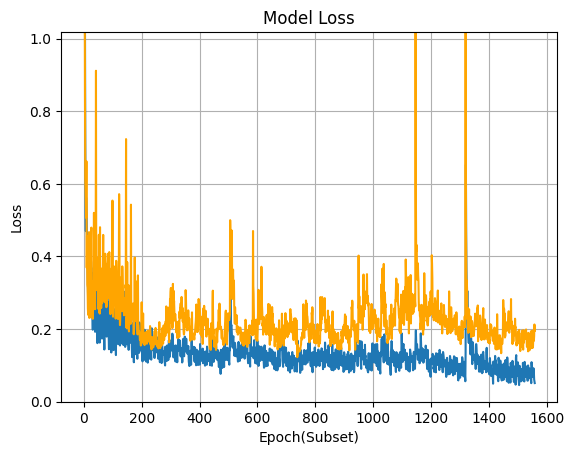

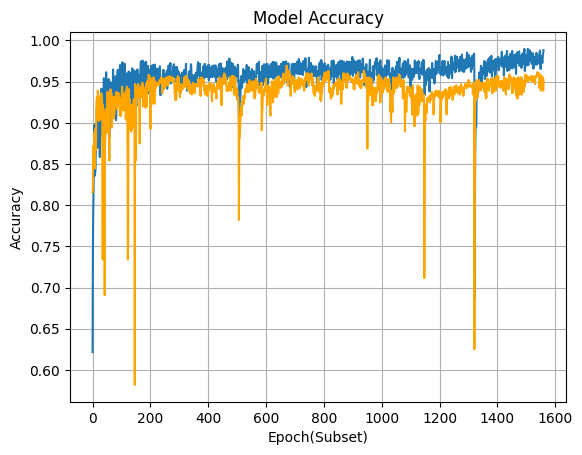

In [34]:
def convert_history(history):
    if isinstance(history, tf.keras.callbacks.History):
        return history.history
    else:
        return history


try:
    EPM = "Epoch(Subset)" if not isinstance(history, tf.keras.callbacks.History) else "Epoch"
    history = convert_history(history)
    # loss
    plt.plot(history["loss"], label="loss")
    try:
        plt.plot(history["val_loss"], label="val_loss", color="orange")
    except (ValueError, NameError):
        print("\033[91mfailed to load val_loss.")
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel(EPM)
    plt.grid(True)
    plt.ylim(top=(max(history["val_loss"][8:]) + min(history["val_loss"])) / 2, bottom=0)
    plt.show()
    # acc
    plt.plot(history["accuracy"], label="accuracy")
    try:
        plt.plot(history["val_accuracy"], label="val_accuracy", color="orange")
    except (ValueError, NameError):
        print("\033[91mfailed to load val_accuracy.")
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel(EPM)
    plt.grid(True)
    plt.show()
except (ValueError, NameError):
    print("\033[91mfailed to load model history.")

## Analyse model Predicting performance

### Gradcam heatmap

#### V2

In [35]:
def compute_heatmap(model, img_array, conv_layer_name, pred_index):
    """
    Helper function to compute the heatmap for a given convolutional layer.
    """
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(conv_layer_name).output, model.output])

    with tf.GradientTape() as tape:
        conv_layer_output, preds = grad_model(img_array)
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_layer_output = conv_layer_output[0]
    heatmap = conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, second_last_conv_layer_name=None, pred_index=None, threshold=0, sensitivity_map=1.0
):
    """
    Function to compute the Grad-CAM heatmap for a specific class, given an input image.
    """
    if pred_index is None:
        preds = model.predict(img_array)
        pred_index = tf.argmax(preds[0])

    # Compute heatmap for the last convolutional layer
    heatmap = compute_heatmap(model, img_array, last_conv_layer_name, pred_index)

    # Apply threshold and adjust sensitivity
    heatmap = np.where(heatmap > threshold, heatmap, 0)
    heatmap = heatmap**sensitivity_map

    if second_last_conv_layer_name is not None:
        # Compute heatmap for the second last convolutional layer
        heatmap_second = compute_heatmap(model, img_array, second_last_conv_layer_name, pred_index)

        # Apply threshold and adjust sensitivity
        heatmap_second = np.where(heatmap_second > threshold, heatmap_second, 0)
        heatmap_second = heatmap_second**sensitivity_map

        # Average the two heatmaps
        heatmap = (heatmap + heatmap_second) / 2.0

    return heatmap

#### V3

### Main test

In [7]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.stats import binom
import gc

# Garbage Collection (memory)
gc.collect()

Extra_EXT = "_T"  # _T or _T_BL
prob_L = 0.9995
tick_spacing = 5
Train_data_test = False
if SAVE_TYPE == "TF":
    # Load the pre-trained model
    model = load_model(f"PAI_model{Extra_EXT}")
else:
    # Load the pre-trained model
    model = load_model(f"PAI_model{Extra_EXT}.h5")

# Ensure the model's input_shape matches your data
assert model.input_shape[1:] == (img_res[0], img_res[1], img_res[2]), "Models input shape doesnt match data."

# Make predictions on validation data
val_predictions = model.predict(x_val)
val_predictions = np.argmax(val_predictions, axis=1)

# Make predictions on Train data
if Train_data_test:
    Train_predictions = model.predict(x_train)
    Train_predictions = np.argmax(Train_predictions, axis=1)

# Make predictions on test data
test_predictions = model.predict(x_test)
test_predictions = np.argmax(test_predictions, axis=1)

# Convert y_val and y_test from one-hot encoder to their original form
y_val_original = np.argmax(y_val, axis=1)
y_test_original = np.argmax(y_test, axis=1)
if Train_data_test:
    y_train_original = np.argmax(y_train, axis=1)

# Calculate accuracy on validation data
val_accuracy = accuracy_score(y_val_original, val_predictions)

# Calculate accuracy on Train data
if Train_data_test:
    Train_accuracy = accuracy_score(y_val_original, Train_predictions)

# Calculate accuracy on test data
test_accuracy = accuracy_score(y_test_original, test_predictions)

# Print acc
if Train_data_test:
    print(f"The accuracy of the model on Train data is {Train_accuracy:.2%}")
print(f"The accuracy of the model on validation data is {val_accuracy:.2%}")
print(f"The accuracy of the model on test data is {test_accuracy:.2%}")

# Visualize the predictions on validation data as a grid of squares
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_val[i])
    plt.title(f"True: {y_val_original[i]}\nPredicted: {val_predictions[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()
# Heatmap
plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    img = x_val[i]
    heatmap = make_gradcam_heatmap(img[np.newaxis, ...], model, "top_conv", sensitivity_map=2)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    # Apply Adaptive Histogram Equalization
    clahe = cv2.createCLAHE(clipLimit=2, tileGridSize=(8, 8))  # Create CLAHE object
    heatmap = clahe.apply(heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    if RANGE_NOM:
        superimposed_img = (heatmap / 255) * 0.5 + img
    else:
        superimposed_img = (heatmap / 255) * 0.5 + (img / 255)
    # clip
    superimposed_img = np.clip(superimposed_img, 0, 1)  # ensure the values are in the range [0, 1]
    plt.imshow(superimposed_img)
    plt.title(f"True: {y_val_original[i]}\nPredicted: {val_predictions[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

# Define the list of labels
labels = ["NORMAL", "PNEUMONIA"]

# Create a confusion matrix for validation data
val_cm = confusion_matrix(y_val_original, val_predictions)

# Create a confusion matrix for test data
test_cm = confusion_matrix(y_test_original, test_predictions)

# Plot the confusion matrix as a heatmap for validation data
plt.figure(figsize=(8, 6))
sns.heatmap(val_cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Validation Data")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plot the confusion matrix as a heatmap for test data
plt.figure(figsize=(8, 6))
sns.heatmap(test_cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix - Test Data")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Define the range of test data sizes to use
data_sizes = range(1, len(x_test), 4)
# Calculate the probability of a wrong prediction based on test accuracy
prob_wrong = 1 - test_accuracy

# Create a list to store the number of incorrect predictions for each test data size
incorrect_predictions = []

# Generate predictions and track incorrect predictions for each data size
for size in tqdm(data_sizes, desc="Predicting", unit="dpb"):
    # Garbage Collection (memory)
    gc.collect()
    # Randomly select a subset of test data
    indices = np.random.choice(len(x_test), size, replace=False)
    x_test_subset = x_test[indices]
    y_test_subset = y_test[indices]

    # Make predictions on the subset of test data
    test_predictions = model.predict(x_test_subset, batch_size=1, verbose=0, max_queue_size=120, workers=1, use_multiprocessing=False)
    test_predictions = np.argmax(test_predictions, axis=1)
    y_test_original_subset = np.argmax(y_test_subset, axis=1)

    # Calculate the number of incorrect predictions
    incorrect_preds = np.sum(test_predictions != y_test_original_subset)
    incorrect_predictions.append(incorrect_preds)

# Plot the number of incorrect predictions vs. the number of data points
plt.figure(figsize=(10, 6))
plt.plot(data_sizes, incorrect_predictions)
plt.xlabel("Number of Data Points")
plt.ylabel("Number of Incorrect Predictions")
# Add gridlines for the x and y axes
plt.grid(True)

# Change the tick spacing for the x and y axes
plt.xticks(np.arange(min(data_sizes), max(data_sizes) + 1, 50))
plt.yticks(np.arange(0, max(incorrect_predictions) + 5, 3))

plt.title("Number of Incorrect Predictions vs. Number of Data Points")
plt.show()

# Define the range of test data sizes to use
data_sizes = range(1, len(x_test), 1)

# Calculate the probability of a wrong prediction based on test accuracy
prob_wrong = 1 - test_accuracy

# Create a list to store the probability of getting at least one wrong answer for each test data size
probabilities = []

# Calculate the probability of getting at least one wrong answer for each data size
for size in data_sizes:
    # Calculate the cumulative distribution function (CDF) of the binomial distribution at 0
    cdf = binom.cdf(0, size, prob_wrong)
    # Subtract the CDF from 1 to get the probability of getting at least one wrong answer
    prob = 1 - cdf
    probabilities.append(prob)

# Find the index of the first data point that has a probability greater than prob_L%
index = next((i for i, p in enumerate(probabilities) if p > prob_L), len(probabilities))

# Limit the x-axis to the first data point that has a probability greater than prob_L%
data_sizes = data_sizes[: index + 1]
probabilities = probabilities[: index + 1]

# Plot the probability vs. the number of data points
plt.figure(figsize=(10, 6))
plt.plot(data_sizes, probabilities)
plt.xlabel("Number of Data Points")
plt.ylabel("Probability")

# Add gridlines for the x and y axes
plt.grid(True)

# Change the tick spacing for the x and y axes
plt.xticks(np.arange(min(data_sizes), max(data_sizes) + 1, tick_spacing + 2))
plt.yticks(np.arange(0, max(probabilities) + 0.1, tick_spacing / 100))

plt.ylim(top=1.01)

plt.title("Probability of Getting at Least One Wrong Answer vs. Number of Data Points")
plt.show()

KeyboardInterrupt: 